#Fully Convolutional

Poenta ovog Notebook-a je proveriti da li potpuno konvoluciona neuronska mreža može naučiti "osobine slike". Ideja je naterati konvoluciju da izdvoji najbitnije osobine slike, a potom te osobine plasirati klasičnom modelu Veštačke inteligencije za uspešnu klasifikaciju.

In [10]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
import os
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer, Reshape, GaussianNoise, Dropout
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
data_dir = "/content/drive/MyDrive/MasinskoUcenjeChestXRay/resources/scaled"

In [4]:
def load_images_to_numpy(src_path: str) -> np.ndarray:
    res = os.listdir(src_path)
    res = map(lambda path: os.path.join(src_path, path), res)
    res = map(Image.open, res)
    res = map(np.asarray, res)
    res = np.stack([*res], axis=0)
    return res

def load_images(src_path: str):
    X_false = load_images_to_numpy(os.path.join(src_path, "NORMAL"))
    y_false = np.zeros((X_false.shape[0],), dtype=np.uint8)

    X_true = load_images_to_numpy(os.path.join(src_path, "PNEUMONIA"))
    y_true = np.ones((X_true.shape[0],), dtype=np.uint8)

    X = np.concatenate([X_false, X_true])
    y = np.concatenate([y_false, y_true])
    return (X, y)

In [5]:
X, y = load_images(os.path.join(data_dir, "train"))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

Veliki broj konvolucionih, agregirajućih i dropout slojeva praćen je jednim jedinim čvorom duboke neuronske mreže. Taj jedan čvor predstavlja običnu logističku regresiju.

In [39]:
def make_model(shape, activation, noise, **kwargs):
    model = Sequential()

    model.add(InputLayer(shape))
    model.add(Rescaling(scale=1/255))
    model.add(GaussianNoise(noise))
    model.add(Reshape((shape[0], shape[1], 1)))

    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (4, 4), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (4, 4), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (5, 5), activation='relu'))
    model.add(MaxPooling2D((2, 5)))

    model.add(Flatten())
    model.add(Dense(1, activation=activation))

    model.compile(**kwargs)
    return model

In [40]:
model = make_model(
  shape=(X_train.shape[1], X_train.shape[2]),
  activation='sigmoid',
  noise=1/255,
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy']
)

In [41]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 280, 400)          0         
                                                                 
 gaussian_noise_8 (GaussianN  (None, 280, 400)         0         
 oise)                                                           
                                                                 
 reshape_8 (Reshape)         (None, 280, 400, 1)       0         
                                                                 
 conv2d_45 (Conv2D)          (None, 278, 398, 16)      160       
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 139, 199, 16)     0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 139, 199, 16)     

In [42]:
model_path = "/content/drive/MyDrive/MasinskoUcenjeChestXRay/models/fully_convolutional"
if not os.path.isdir(model_path):
        os.makedirs(model_path)
model_checkpoints_path = os.path.join(model_path, "checkpoint")
if not os.path.isdir(model_checkpoints_path):
        os.makedirs(model_checkpoints_path)

Zbog velike nestabilnosti, ovaj model ću duže trenirati (i dalje se bira model iz najbolje epohe)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    validation_split=0.1,
    callbacks=[
        ModelCheckpoint(
          filepath=os.path.join(model_checkpoints_path, "{epoch:02d}.h5"),
          save_best_only=True,
          monitor='val_loss',
          mode='min'
        )
    ]
)

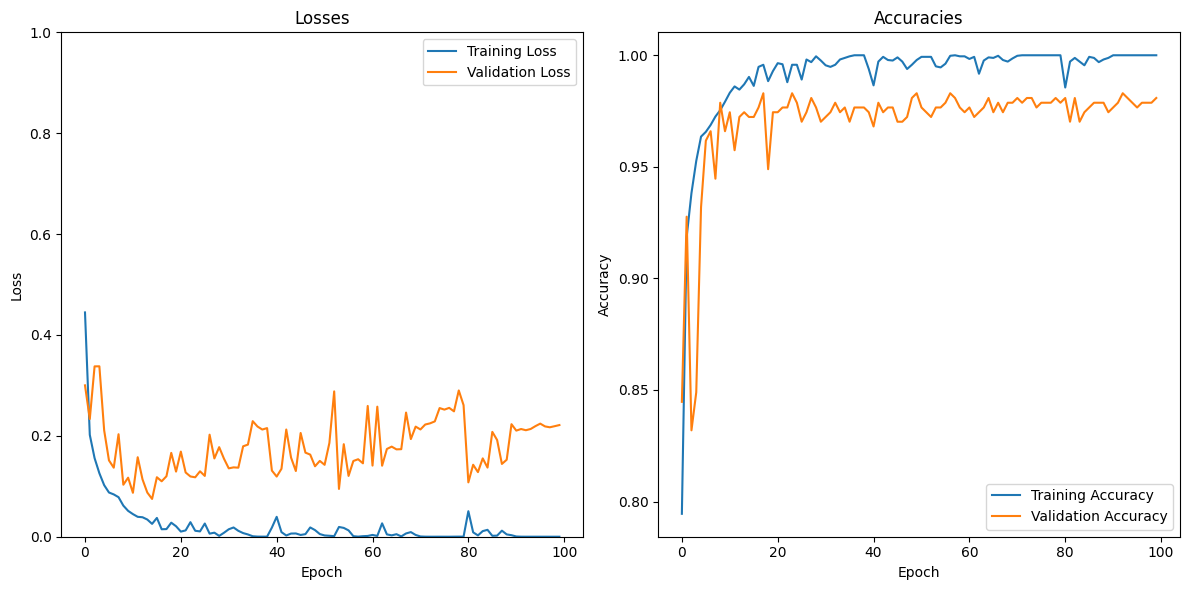

In [44]:
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()

Model je postigao vrhunac u epohi 15, mada nestabilno deluje kao da bolje od toga neće uspeti bez preprilagođavanja.

In [45]:
best_model = load_model(os.path.join(model_checkpoints_path, "15.h5"))

In [46]:
y_pred = best_model.predict(X_test)
y_pred = np.where(y_pred < 0.5, 0, 1)

17/17 [==============================] - 1s 36ms/step


In [47]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       134
           1       0.99      0.99      0.99       388

    accuracy                           0.99       522
   macro avg       0.99      0.98      0.98       522
weighted avg       0.99      0.99      0.99       522



In [48]:
pd.DataFrame(confusion_matrix(y_test, y_pred), index=["NORMAL", "PNEUMONIA"], columns=["NORMAL", "PNEUMONIA"])

,NORMAL,PNEUMONIA
NORMAL,130,4
PNEUMONIA,2,386


S obziron da jedan neuron predstavlja nešto nalik logističkoj regresiji, može se reći da je sama konvolucija uspešno naučila odlike slika. Na test skupu ovaj model ostvaruje najbolje performanse (što se jednostavno može pripisati tome da je veći od prethodnih i koristi sve malopre pomenute tehnike)

In [49]:
best_model.save(os.path.join(model_path, "model.h5"))